<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointnegpos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('all')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Data/Tweets_clean_data.csv')
df = df.sample(frac=1)

Mounted at /content/drive
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...

In [2]:
category_dict = {"anger":[1,0,0,0],"sadness":[0,1,0,0],"fear":[0,0,1,0],"joy":[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['Tweet']]
data_cat = np.array([category_dict[x] for x in df['Emotion']])

In [3]:
print(data_tweet[:5])
print(data_cat[:5])

[['i', 'hate', 'not', 'having', 'the', 'answers', 'i', 'need', 'tomourssuck', 'prayinsnotcancer', 'angry'], ['literally', 'dying', 'and', 'living', 'at', 'the', 'same', 'time', 'as', 'i', 'catch', 'up', 'on', 'ver', 's', 'twitter', 'if', 'you', 'are', 'not', 'following', 'him', 'your', 'life', 'is', 'basic'], ['“it', 'is', 'not', 'death', 'that', 'most', 'people', 'are', 'afraid', 'of', 'it', 'is', 'getting', 'to', 'the', 'end', 'of', 'life', 'only', 'to', 'realize', 'that', 'you', 'never', 'truly', 'lived', '”'], ['my', 'doctor', 'is', 'giving', 'me', 'flower', 'extract', 'to', 'relieve', 'anxiety', 'and', 'reduce', 'panic', 'attacks', 'tears', 'of', 'happiness'], ['the', 'bitter', 'the', 'battle', 'the', 'sweeter', 'the', 'victory']]
[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]]


In [4]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [5]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [6]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [7]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])
mul_factor=1.5

In [8]:
positive = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/CodeMix/positive-words.csv')
positive = list(positive['0'][1:])
negative = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/CodeMix/negative-words.csv')
negative = list(negative['0'][2:])
pn_dict = {}
for i in range(len(positive)):
  pn_dict[positive[i]] = 1

for i in range(len(negative)):
  pn_dict[negative[i]] = -1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.30, random_state=42)
X_train = [nltk.pos_tag(x) for x in X_train]
X_test = [nltk.pos_tag(x) for x in X_test]
X_train = [[(i[0],i[1],pn_dict.get(i[0],1)) for i in x] for x in X_train]
X_test = [[(i[0],i[1],pn_dict.get(i[0],1)) for i in x] for x in X_test]
result_table = [0,0,0,0,0,0,0,0,0]

In [22]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(w2v.wv.word_vec(i[0]),i[1],i[2]) for i in x if i[0] in vocab]
        l=len(tweet)
        for i in range(l):
          tweet[i]=((tweet[i][0]*tweet[i][2]),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='NN' or tweet[i][1][:2]=='RB' or tweet[i][1][:2]=='VB':
            tweet[i]=((tweet[i][0])*mul_factor,tweet[i][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)          
      
def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(vocab[i[0]],i[1],i[2]) for i in x if i[0] in vocab.keys()]
        l=len(tweet)
        for i in range(l):
          tweet[i]=((tweet[i][0]*tweet[i][2]),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='NN' or tweet[i][1][:2]=='RB' or tweet[i][1][:2]=='VB':
            tweet[i]=((tweet[i][0])*mul_factor,tweet[i][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

In [23]:
epochs = 50

In [24]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


Epoch 1/50
49/49 [==============================] - 3s 66ms/step - loss: 1.3785 - accuracy: 0.3096
Epoch 2/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3763 - accuracy: 0.3124
Epoch 3/50
49/49 [==============================] - 3s 68ms/step - loss: 1.3751 - accuracy: 0.3124
Epoch 4/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3638 - accuracy: 0.3361
Epoch 5/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3412 - accuracy: 0.3588
Epoch 6/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3267 - accuracy: 0.3818
Epoch 7/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3125 - accuracy: 0.3918
Epoch 8/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3005 - accuracy: 0.3951
Epoch 9/50
49/49 [==============================] - 3s 67ms/step - loss: 1.2849 - accuracy: 0.4051
Epoch 10/50
49/49 [==============================] - 3s 68ms/step - loss: 1.2737 - accuracy: 0.4076
Epoch 11/

In [25]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

Epoch 1/50
49/49 [==============================] - 4s 72ms/step - loss: 1.3763 - accuracy: 0.3029
Epoch 2/50
49/49 [==============================] - 4s 76ms/step - loss: 1.3568 - accuracy: 0.3300
Epoch 3/50
49/49 [==============================] - 4s 75ms/step - loss: 1.3190 - accuracy: 0.3690
Epoch 4/50
49/49 [==============================] - 4s 74ms/step - loss: 1.2841 - accuracy: 0.4024
Epoch 5/50
49/49 [==============================] - 4s 74ms/step - loss: 1.2550 - accuracy: 0.4335
Epoch 6/50
49/49 [==============================] - 4s 74ms/step - loss: 1.2286 - accuracy: 0.4476
Epoch 7/50
49/49 [==============================] - 4s 75ms/step - loss: 1.2055 - accuracy: 0.4669
Epoch 8/50
49/49 [==============================] - 4s 75ms/step - loss: 1.1818 - accuracy: 0.4886
Epoch 9/50
49/49 [==============================] - 4s 75ms/step - loss: 1.1590 - accuracy: 0.4959
Epoch 10/50
49/49 [==============================] - 4s 72ms/step - loss: 1.1379 - accuracy: 0.5106
Epoch 11/

In [28]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

Epoch 1/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3809 - accuracy: 0.2978
Epoch 2/50
49/49 [==============================] - 5s 102ms/step - loss: 1.3697 - accuracy: 0.3176
Epoch 3/50
49/49 [==============================] - 5s 101ms/step - loss: 1.3601 - accuracy: 0.3190
Epoch 4/50
49/49 [==============================] - 5s 102ms/step - loss: 1.3476 - accuracy: 0.3476
Epoch 5/50
49/49 [==============================] - 5s 102ms/step - loss: 1.3311 - accuracy: 0.3612
Epoch 6/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3262 - accuracy: 0.3561
Epoch 7/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3196 - accuracy: 0.3737
Epoch 8/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3110 - accuracy: 0.3837
Epoch 9/50
49/49 [==============================] - 5s 104ms/step - loss: 1.2739 - accuracy: 0.4145
Epoch 10/50
49/49 [==============================] - 5s 105ms/step - loss: 1.2488 - accuracy: 0.4300

In [29]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_lstm = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

Epoch 1/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3787 - accuracy: 0.3076
Epoch 2/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3762 - accuracy: 0.3124
Epoch 3/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3761 - accuracy: 0.3124
Epoch 4/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3749 - accuracy: 0.3104
Epoch 5/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3745 - accuracy: 0.3122
Epoch 6/50
49/49 [==============================] - 3s 71ms/step - loss: 1.3622 - accuracy: 0.3186
Epoch 7/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3510 - accuracy: 0.3088
Epoch 8/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3681 - accuracy: 0.3133
Epoch 9/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3744 - accuracy: 0.3124
Epoch 10/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3506 - accuracy: 0.3322
Epoch 11/

In [30]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

Epoch 1/50
49/49 [==============================] - 4s 77ms/step - loss: 1.3752 - accuracy: 0.3092
Epoch 2/50
49/49 [==============================] - 4s 79ms/step - loss: 1.3564 - accuracy: 0.3308
Epoch 3/50
49/49 [==============================] - 4s 76ms/step - loss: 1.3271 - accuracy: 0.3767
Epoch 4/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2907 - accuracy: 0.4084
Epoch 5/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2538 - accuracy: 0.4384
Epoch 6/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2209 - accuracy: 0.4553
Epoch 7/50
49/49 [==============================] - 4s 76ms/step - loss: 1.1905 - accuracy: 0.4802
Epoch 8/50
49/49 [==============================] - 4s 77ms/step - loss: 1.1675 - accuracy: 0.4982
Epoch 9/50
49/49 [==============================] - 4s 75ms/step - loss: 1.1403 - accuracy: 0.5169
Epoch 10/50
49/49 [==============================] - 4s 78ms/step - loss: 1.1155 - accuracy: 0.5343
Epoch 11/

In [31]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3816 - accuracy: 0.3033
Epoch 2/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3706 - accuracy: 0.3196
Epoch 3/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3630 - accuracy: 0.3257
Epoch 4/50
49/49 [==============================] - 5s 109ms/step - loss: 1.3620 - accuracy: 0.3386
Epoch 5/50
49/49 [==============================] - 5s 106ms/step - loss: 1.3511 - accuracy: 0.3463
Epoch 6/50
49/49 [==============================] - 5s 109ms/step - loss: 1.3545 - accuracy: 0.3410
Epoch 7/50
49/49 [==============================] - 5s 107ms/step - loss: 1.3483 - accuracy: 0.3480
Epoch 8/50
49/49 [==============================] - 5s 108ms/step - loss: 1.3370 - accuracy: 0.3718
Epoch 9/50
49/49 [==============================] - 5s 107ms/step - loss: 1.3343 - accuracy: 0.3678
Epoch 10/50
49/49 [==============================] - 5s 106ms/step - loss: 1.3175 - accuracy: 0.3808

In [32]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_lstm = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


Epoch 1/50
49/49 [==============================] - 1s 24ms/step - loss: 1.3791 - accuracy: 0.3080
Epoch 2/50
49/49 [==============================] - 1s 25ms/step - loss: 1.3749 - accuracy: 0.3118
Epoch 3/50
49/49 [==============================] - 1s 25ms/step - loss: 1.2965 - accuracy: 0.3716
Epoch 4/50
49/49 [==============================] - 1s 25ms/step - loss: 1.2056 - accuracy: 0.4339
Epoch 5/50
49/49 [==============================] - 1s 26ms/step - loss: 1.1363 - accuracy: 0.4563
Epoch 6/50
49/49 [==============================] - 1s 25ms/step - loss: 1.0848 - accuracy: 0.4761
Epoch 7/50
49/49 [==============================] - 1s 26ms/step - loss: 1.0325 - accuracy: 0.4871
Epoch 8/50
49/49 [==============================] - 1s 25ms/step - loss: 0.9977 - accuracy: 0.5184
Epoch 9/50
49/49 [==============================] - 1s 24ms/step - loss: 0.9417 - accuracy: 0.5671
Epoch 10/50
49/49 [==============================] - 1s 25ms/step - loss: 0.8903 - accuracy: 0.6029
Epoch 11/

In [26]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

Epoch 1/50
49/49 [==============================] - 2s 32ms/step - loss: 1.3492 - accuracy: 0.3435
Epoch 2/50
49/49 [==============================] - 2s 33ms/step - loss: 1.1832 - accuracy: 0.4673
Epoch 3/50
49/49 [==============================] - 2s 33ms/step - loss: 1.0371 - accuracy: 0.5541
Epoch 4/50
49/49 [==============================] - 2s 32ms/step - loss: 0.8812 - accuracy: 0.6429
Epoch 5/50
49/49 [==============================] - 2s 33ms/step - loss: 0.7330 - accuracy: 0.7190
Epoch 6/50
49/49 [==============================] - 2s 32ms/step - loss: 0.6119 - accuracy: 0.7751
Epoch 7/50
49/49 [==============================] - 2s 33ms/step - loss: 0.5343 - accuracy: 0.8053
Epoch 8/50
49/49 [==============================] - 2s 32ms/step - loss: 0.4942 - accuracy: 0.8190
Epoch 9/50
49/49 [==============================] - 2s 33ms/step - loss: 0.4284 - accuracy: 0.8451
Epoch 10/50
49/49 [==============================] - 2s 32ms/step - loss: 0.3535 - accuracy: 0.8778
Epoch 11/

In [33]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3813 - accuracy: 0.3033
Epoch 2/50
49/49 [==============================] - 3s 70ms/step - loss: 1.3497 - accuracy: 0.3337
Epoch 3/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3060 - accuracy: 0.3776
Epoch 4/50
49/49 [==============================] - 3s 70ms/step - loss: 1.2574 - accuracy: 0.4151
Epoch 5/50
49/49 [==============================] - 3s 71ms/step - loss: 1.2216 - accuracy: 0.4561
Epoch 6/50
49/49 [==============================] - 3s 69ms/step - loss: 1.1912 - accuracy: 0.4735
Epoch 7/50
49/49 [==============================] - 3s 68ms/step - loss: 1.1608 - accuracy: 0.4929
Epoch 8/50
49/49 [==============================] - 3s 69ms/step - loss: 1.1286 - accuracy: 0.5133
Epoch 9/50
49/49 [==============================] - 3s 69ms/step - loss: 1.1079 - accuracy: 0.5267
Epoch 10/50
49/49 [==============================] - 3s 70ms/step - loss: 1.0938 - accuracy: 0.5312
Epoch 11/

	Lstm			BiLstm			Rnn
sg [0.5361904501914978, 0.6047618985176086, 0.3400000035762787]
cbow [0.5166666507720947, 0.6028571724891663, 0.3090476095676422]
glove [0.7628571391105652, 0.7514285445213318, 0.44952380657196045]
{'loss': [1.3763351440429688, 1.356803297996521, 1.3190114498138428, 1.284084677696228, 1.2550052404403687, 1.2286421060562134, 1.20547354221344, 1.181769847869873, 1.1589831113815308, 1.1379472017288208, 1.1085337400436401, 1.078101634979248, 1.0521206855773926, 1.0137971639633179, 0.9723711609840393, 0.937044084072113, 0.9069138765335083, 0.8722113966941833, 0.8317484855651855, 0.7802574634552002, 0.7301841974258423, 0.7055675983428955, 0.672855019569397, 0.6291521787643433, 0.6345160007476807, 0.57338947057724, 0.5776135325431824, 0.5258246660232544, 0.5532552003860474, 0.4977792799472809, 0.46125921607017517, 0.7827885150909424, 0.7040295004844666, 0.5877126455307007, 0.5225017070770264, 0.47439706325531006, 0.4324001371860504, 0.40017327666282654, 0.3716647922992706

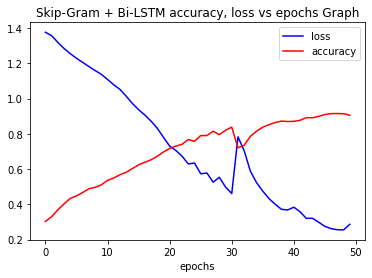

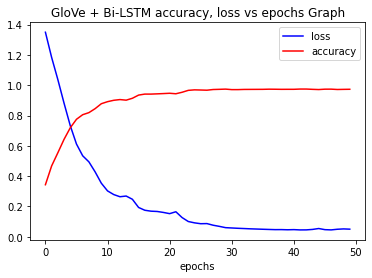

In [34]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

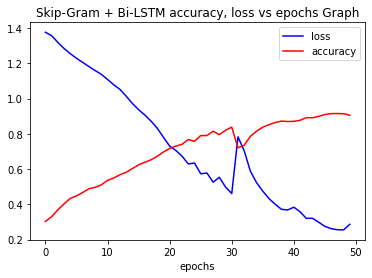

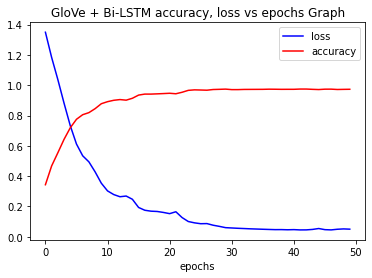

In [27]:
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()